Training a BDT to predict $\delta C_9$ on an event-by-event basis

Setup

In [1]:
import numpy as np
from scipy.special import logsumexp

from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

from library.plotting import setup_high_quality_mpl_params
from library.datasets import Aggregated_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

In [68]:
def predict_set_likelihood(x, clf):
    """
    log sum_i p( z | x_i )

    x : ndarray of events (set with same input label)
    clf : sklearn classifier 
    """
    pred_prob = clf.predict_proba(x)
    pred = np.sum(np.log(pred_prob), axis=0)
    return pred


def predict_likelihood_over_bins(x, y, clf):
    """
    log sum_i p ( z | x_i ) for each value of z

    x : ndarray of events (matrix with input label as rows)
    y : ndarray of bins
    clf : sklearn classifier
    """
    bins = np.unique(y)
    preds = []
    for bin in bins:
        x_bin = x[y==bin]
        pred = predict_set_likelihood(x_bin, clf)
        preds.append(np.expand_dims(pred, axis=0))
    preds = np.concatenate(preds, axis=0)
    assert preds.shape == (len(bins), len(bins))
    return preds


def predict_proba_over_bins(x, y, clf):
    """
    p (z | x_1, ..., x_N) = sum_i log p(z|x_i) - lse({sum_i log p(z_j|x_i)}_j)
    """

    def to_matrix(a):
        a = np.tile(a, (len(a), 1))
        a = a.T
        return a
    
    predicted_likelihoods = predict_likelihood_over_bins(x, y, clf)
    lse_predicted_likelihoods = logsumexp(predicted_likelihoods, axis=1)
    lse_predicted_likelihoods_matrix = to_matrix(lse_predicted_likelihoods)
    predicted_probabilities = predicted_likelihoods - lse_predicted_likelihoods_matrix
    return predicted_probabilities



def predict_expected_value_over_bins(x, y, clf, bin_values):
    predicted_likelihoods = predict_likelihood_over_bins(x, y, clf)
    lse_predicted_likelihoods = logsumexp(predicted_likelihoods, axis=1)
    log_bin_values = np.tile(np.log(bin_values), (len(bin_values), 1))
    weighted_predicted_likelihoods = predicted_likelihoods + log_bin_values
    lse_weighted_predicted_likelihoods = logsumexp(weighted_predicted_likelihoods, axis=1)
    log_expected_value = lse_weighted_predicted_likelihoods - lse_predicted_likelihoods
    expected_value = np.exp(log_expected_value)
    return log_expected_value, expected_value


def predict_expected_value_over_bootstrapped_trials(x, y, n_trials, n_events, clf, bin_values):
    """
    x : ndarray of events
    y : ndarray of bins
    n_trials : number of bootstrapped sample sets
    n_events : number of events to bootstrap per sample set
    """
    expected_value_over_trials = []
    for trial in range(n_trials):
        boot_x, boot_y = bootstrap_over_bins(x, y, n_events)
        _, expected_values = predict_expected_value_over_bins(boot_x, boot_y, clf, bin_values)
        expected_value_over_trials.append(np.expand_dims(expected_values, axis=0))
    expected_value_over_trials = np.concatenate(expected_value_over_trials)
    return expected_value_over_trials


def predict_proba_over_bootstrapped_trials(x, y, n_trials, n_events, clf):
    """
    x : ndarray of events
    y : ndarray of bins
    n_trials : number of bootstrapped sample sets
    n_events : number of events to bootstrap per sample set
    clf : classifier
    """
    proba_over_trials = []
    for trial in range(n_trials):
        boot_x, boot_y = bootstrap_over_bins(x, y, n_events)
        log_proba = predict_proba_over_bins(boot_x, boot_y, clf)
        proba_over_trials.append(np.expand_dims(log_proba, axis=0))
    proba_over_trials = np.concatenate(proba_over_trials)
    return proba_over_trials


def log_loss_over_bootstrapped_trials(x, y, n_trials, n_events, clf,):
    def log_loss(log_proba):
        d = np.diagonal(log_proba, axis1=1, axis2=2)
        loss = d.mean()
        return loss
    log_proba_over_trials = predict_proba_over_bootstrapped_trials(x, y, n_trials, n_events, clf)
    loss = log_loss(log_proba_over_trials)
    return loss


def plot_prob_over_bins(fig, ax, predictions_over_bins, bin_values, cmap=plt.cm.viridis):
    """
    predictions_over_bins : ndarray of bin probabilities
        (rows are input bins, columns are bin predictions)
    bin_values : ndarray of the value each bin represents 
    """

    bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    for b_v, pred in zip(bin_values, predictions_over_bins):
        # pred_bin = np.argmax(pred)
        # ax.scatter(bin_values[pred_bin], np.max(pred), color=cmap(norm(b_v)), edgecolors="black", zorder=100)
        ax.plot(bin_values, pred, color=cmap(norm(b_v)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r"$\delta C_9$")
    ax.set_xlabel(r"$\delta C_9$")
    ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")


def plot_prediction_linearity(
        ax,
        input_values, avg_pred, stdev_pred, ref_line_buffer=0.05, 
        xlim=None, ylim=None, xlabel=None, ylabel=None
):
    """
    input_values : value corresponding to each bin index
    avg_pred : ndarray of average prediction per input bin
    stdev_pred : ndarray of standard deviation of prediction per input bin 
    ref_line_buffer : extra amount to extend reference line
    xlim : x limits
    ylim : y limits
    """
        
    ax.scatter(input_values, avg_pred, label="Avg.", color="firebrick", s=16, zorder=5)
    ax.errorbar(input_values, avg_pred, yerr=stdev_pred, fmt="none", elinewidth=0.5, capsize=0.5, color="black", label="Std. Dev.", zorder=10)

    ref_ticks = np.linspace(np.min(input_values)-ref_line_buffer, np.max(input_values)+ref_line_buffer, 2)
    ax.plot(
        ref_ticks, ref_ticks,
        label="Ref. Line (Slope = 1)",
        color="grey",
        linewidth=0.5,
        zorder=0
    )

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    ax.legend()
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)


def make_plot_note(ax, content, fontsize):
    ax.text(1,1.01, content, horizontalalignment="right", verticalalignment="bottom", transform=ax.transAxes, fontsize=fontsize)


setup_high_quality_mpl_params()
# mpl.rcParams.update(mpl.rcParamsDefault)

Load Data

In [3]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

normalize = True
q_squared_veto = True

train_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="train", raw_trials=range(0,20), save_dir=save_dir)
eval_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="eval", raw_trials=range(20,30), save_dir=save_dir)
test_dataset = Aggregated_Signal_Binned_Dataset(level=level, split="test", raw_trials=range(30,40), save_dir=save_dir)

if regenerate:
    # train_dataset.generate(raw_signal_dir, std_scale=normalize, q_squared_veto=q_squared_veto)
    # eval_dataset.generate(raw_signal_dir, std_scale=normalize, q_squared_veto=q_squared_veto)
    test_dataset.generate(raw_signal_dir, std_scale=normalize, q_squared_veto=q_squared_veto)

eval_dataset.load()
train_dataset.load()
test_dataset.load()

np.testing.assert_equal(train_dataset.bin_values, eval_dataset.bin_values, test_dataset.bin_values)

train_x = train_dataset.features.numpy()
train_y = train_dataset.labels.numpy()

eval_x = eval_dataset.features.numpy()
eval_y = eval_dataset.labels.numpy()

test_x = test_dataset.features.numpy()
test_y = test_dataset.labels.numpy()

opened raw file: [1/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_30_re.pkl
opened raw file: [2/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_31_re.pkl
opened raw file: [3/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_32_re.pkl
opened raw file: [4/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_33_re.pkl
opened raw file: [5/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_34_re.pkl
opened raw file: [6/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_35_re.pkl
opened raw file: [7/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_36_re.pkl
opened raw file: [8/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_37_re.pkl
opened raw file: [9/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_38_re.pkl
opened raw file: [10/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_39_re.pkl
opened raw file: [11/439] ..\..\state\new_physics\data\raw\signal\dc9_-0.08_30_re.pkl
opened raw file: [12/439] ..\..\state\new_physics\data\raw\sign

In [4]:
test_x.shape

(3076392, 4)

In [5]:
eval_x.shape

(3378892, 4)

Observe Class Balance

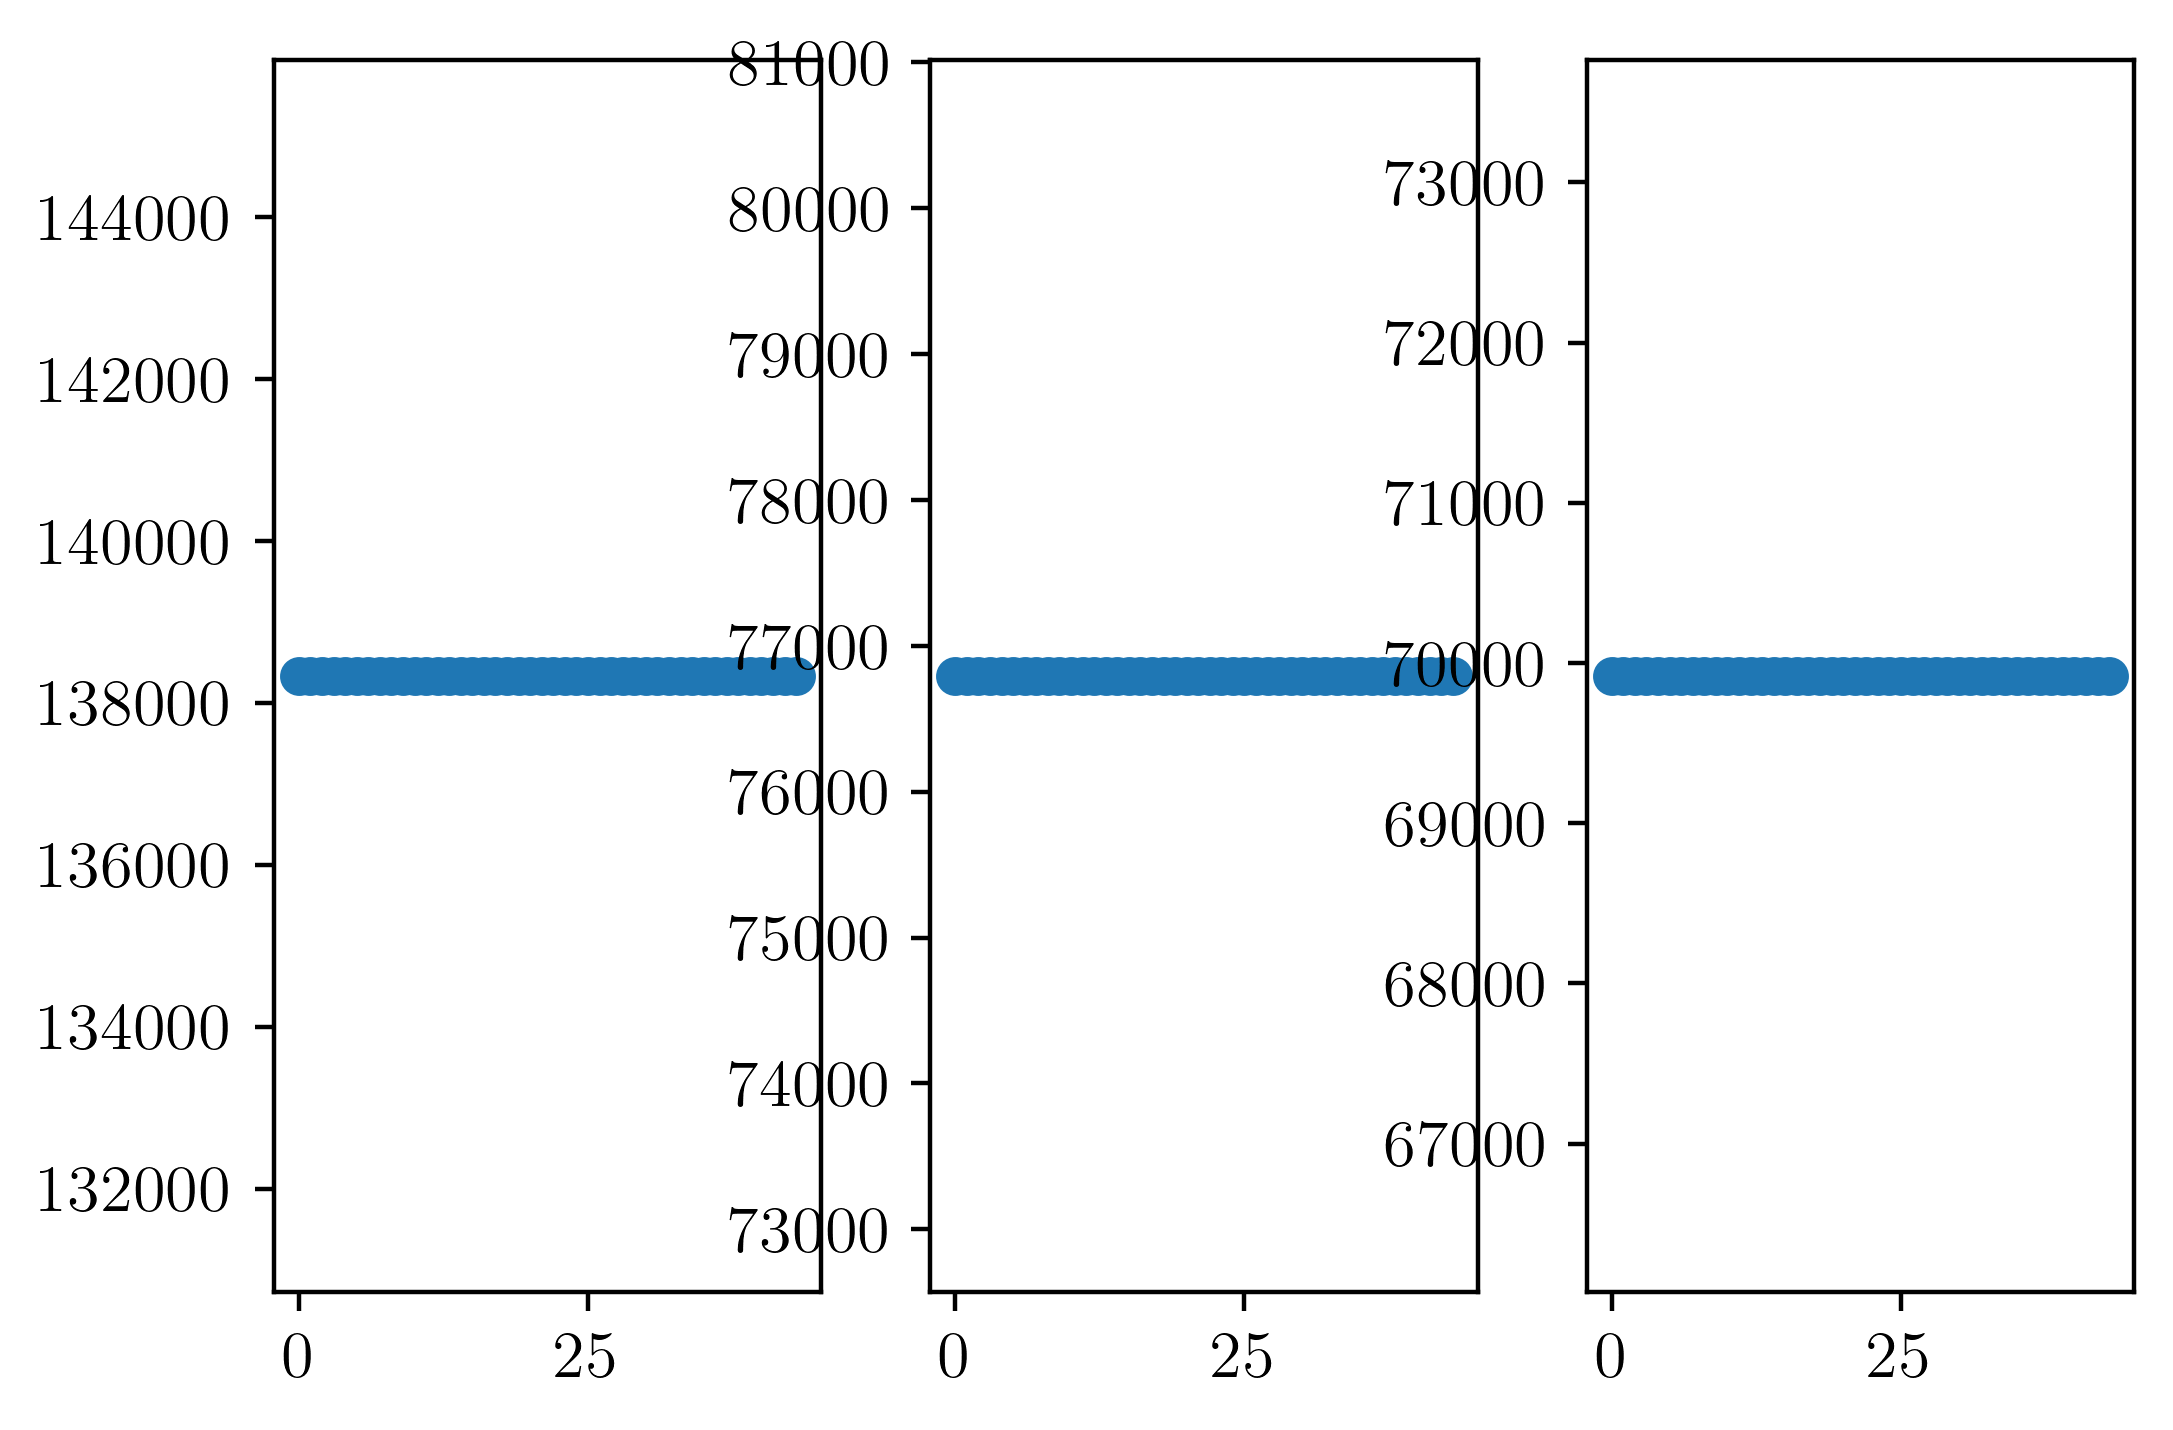

In [6]:
_, axs = plt.subplots(1,3)

# Training data
bins, counts = np.unique(train_y, return_counts=True)
axs[0].scatter(bins, counts)

# Evaluation data
bins, counts = np.unique(eval_y, return_counts=True)
axs[1].scatter(bins, counts)

# Evaluation data
bins, counts = np.unique(test_y, return_counts=True)
axs[2].scatter(bins, counts)

plt.show()

Fit the BDT

In [7]:
clf = HistGradientBoostingClassifier(
    max_iter=200, #200, 
    early_stopping=False,
    verbose=5, 
    max_depth=1, 
    max_leaf_nodes=2, 
    max_bins=2,
    learning_rate=0.05,
    # l2_regularization=10000,
).fit(train_x, train_y)

Binning 0.195 GB of training data: 0.200 s
Fitting gradient boosted rounds:
[1/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.980s
[2/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.133s
[3/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.186s
[4/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.191s
[5/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.903s
[6/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 11.544s
[7/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 6.377s
[8/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.843s
[9/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.981s
[10/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 6.177s
[11/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.745s
[12/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.622s
[13/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.946s
[14/200] 44 trees, 88 leaves (2 on avg), max depth = 1, in 5.635s
[15/200]

Evaluate Model Performance

In [5]:
# On all training data
preds_all_train = predict_likelihood_over_bins(train_x, train_y, clf)

In [ ]:
fig, ax = plt.subplots(layout="constrained")
plot_likelihood_over_bins(fig, ax, preds_all_train, train_dataset.bin_values)
make_plot_note(ax, "All Training Data", fontsize="x-large")
plt.show()

In [7]:
# On all eval data
preds_all_eval = predict_likelihood_over_bins(eval_x, eval_y, clf)

In [ ]:
fig, ax = plt.subplots(layout="constrained")
plot_likelihood_over_bins(fig, ax, preds_all_eval, eval_dataset.bin_values)
make_plot_note(ax, "All Validation Data", fontsize="large")
plt.show()

In [ ]:
shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1
log_expected_values, expected_values = predict_expected_value_over_bins(train_x, train_y, clf, shifted_bin_values)
plt.scatter(shifted_bin_values, expected_values)
plt.plot(shifted_bin_values, shifted_bin_values)

In [ ]:
shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1
log_expected_values, expected_values = predict_expected_value_over_bins(eval_x, eval_y, clf, shifted_bin_values)
plt.scatter(shifted_bin_values, expected_values)
plt.plot(shifted_bin_values, shifted_bin_values)

In [53]:
# On bootstrapped data
boot_x, boot_y = bootstrap_over_bins(eval_x, eval_y, 24_000)
preds = predict_proba_over_bins(boot_x, boot_y, clf)

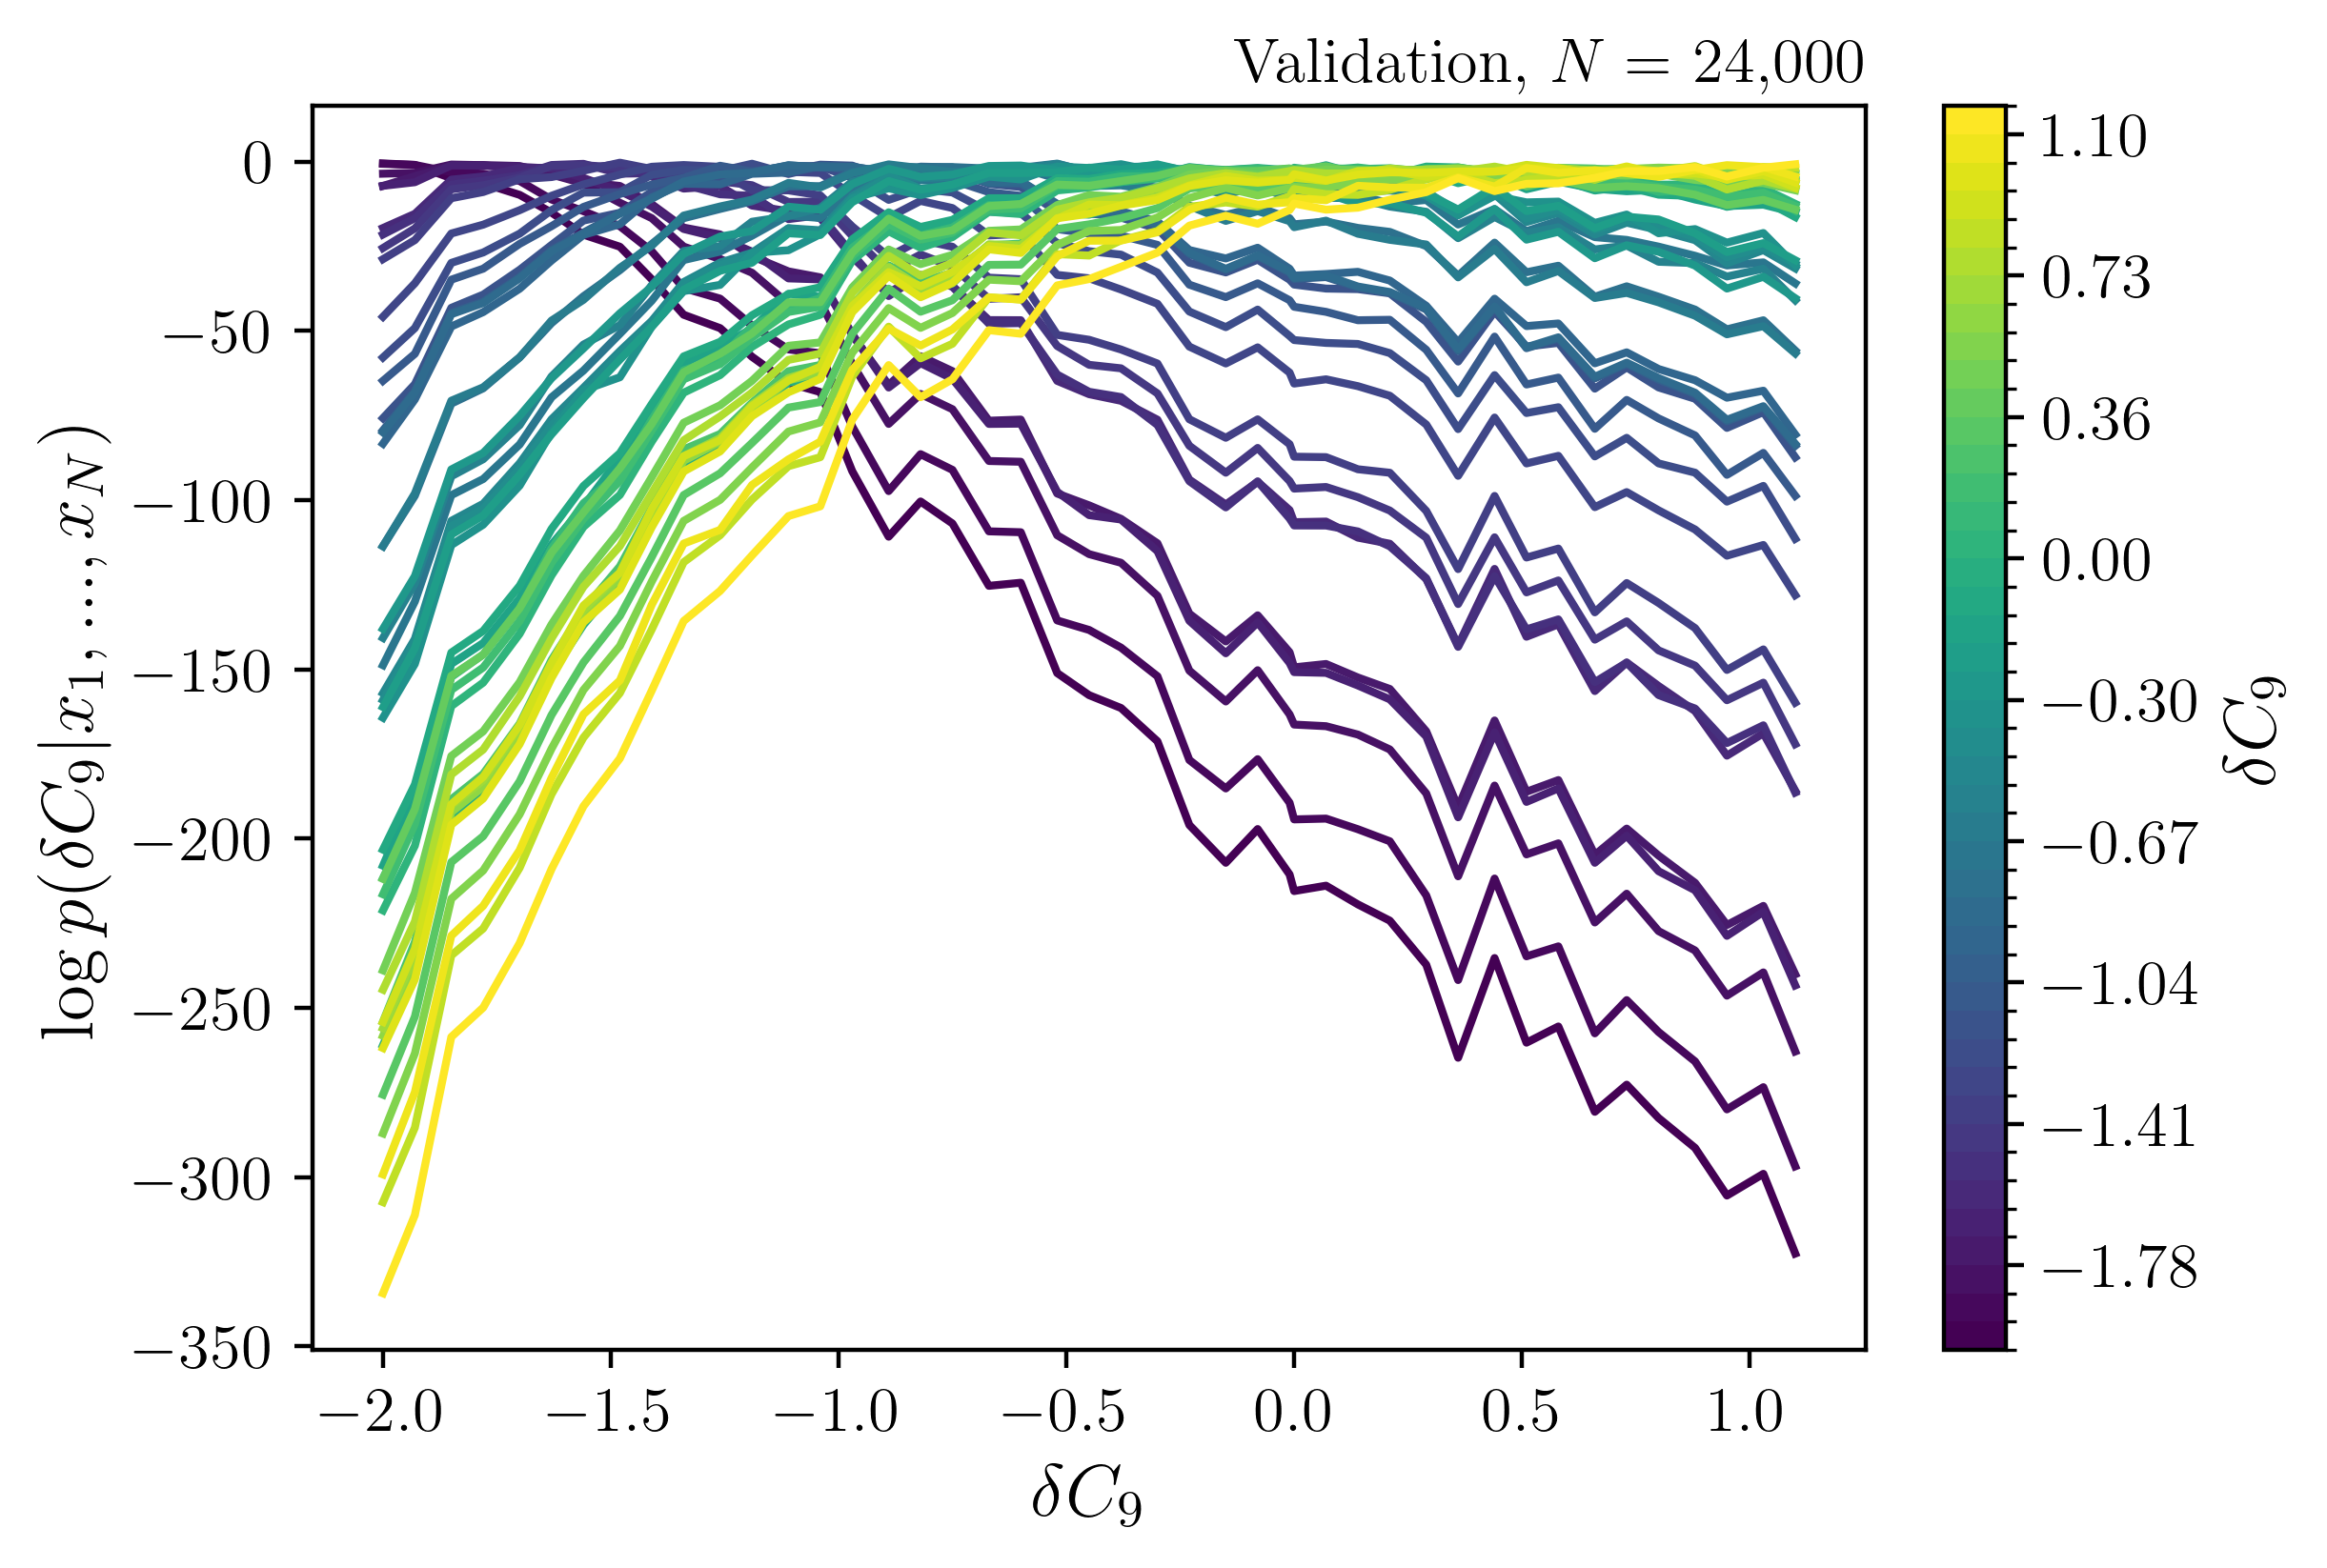

In [57]:
fig, ax = plt.subplots(layout="constrained")
plot_prob_over_bins(fig, ax, preds, eval_dataset.bin_values)
make_plot_note(ax, r"Validation, $N =$ 24,000", fontsize="large")
plt.show()

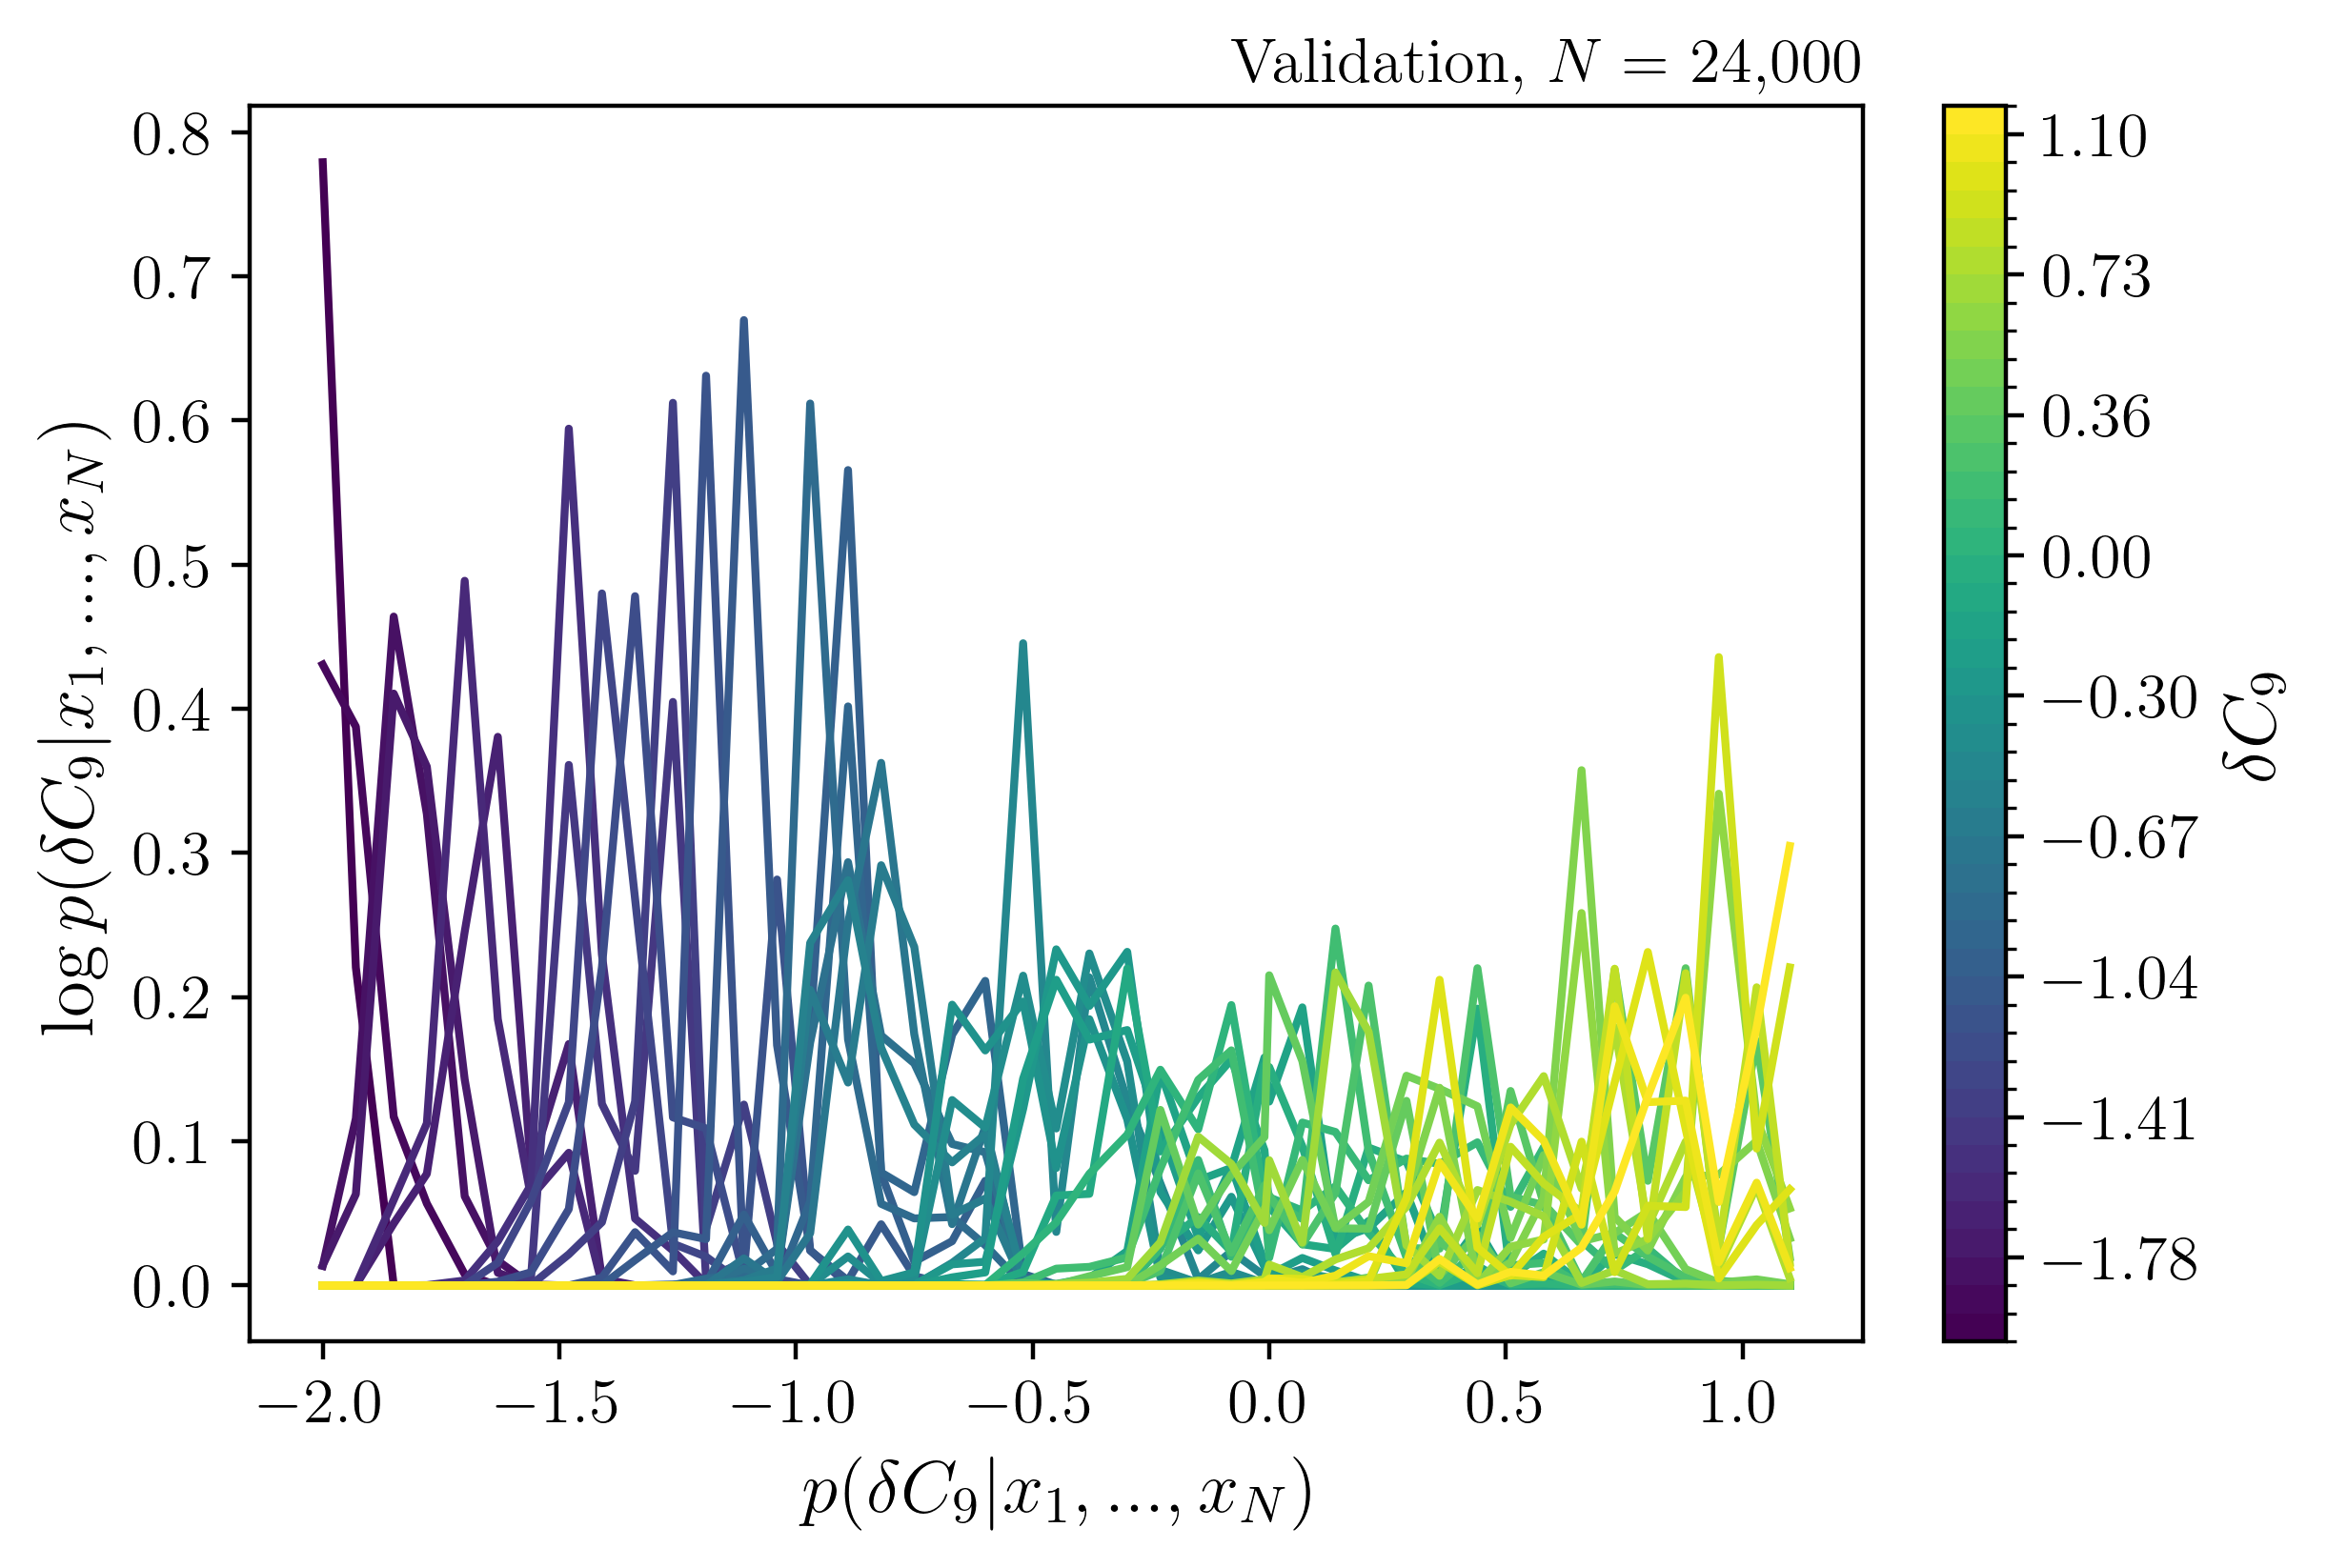

In [59]:
# regular probabilites

boot_x, boot_y = bootstrap_over_bins(eval_x, eval_y, 24_000)
preds = predict_proba_over_bins(boot_x, boot_y, clf)

preds = np.exp(preds)

fig, ax = plt.subplots(layout="constrained")
plot_prob_over_bins(fig, ax, preds, eval_dataset.bin_values)
ax.set_xlabel(r"$p(\delta C_9 | x_1, ..., x_N)$")
make_plot_note(ax, r"Validation, $N =$ 24,000", fontsize="large")
plt.show()


In [ ]:
shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1
log_expected_values, expected_values = predict_expected_value_over_bins(boot_x, boot_y, clf, shifted_bin_values)
plt.scatter(shifted_bin_values, expected_values)
plt.plot(shifted_bin_values, shifted_bin_values)

In [12]:
# Over multiple bootstrapped trials

shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1

expected_values_over_trials = predict_expected_value_over_bootstrapped_trials(test_x, test_y, 10, 24_000, clf, shifted_bin_values)

avg_expected_values = np.mean(expected_values_over_trials, axis=0)
stdev_expected_values = np.std(expected_values_over_trials, axis=0)

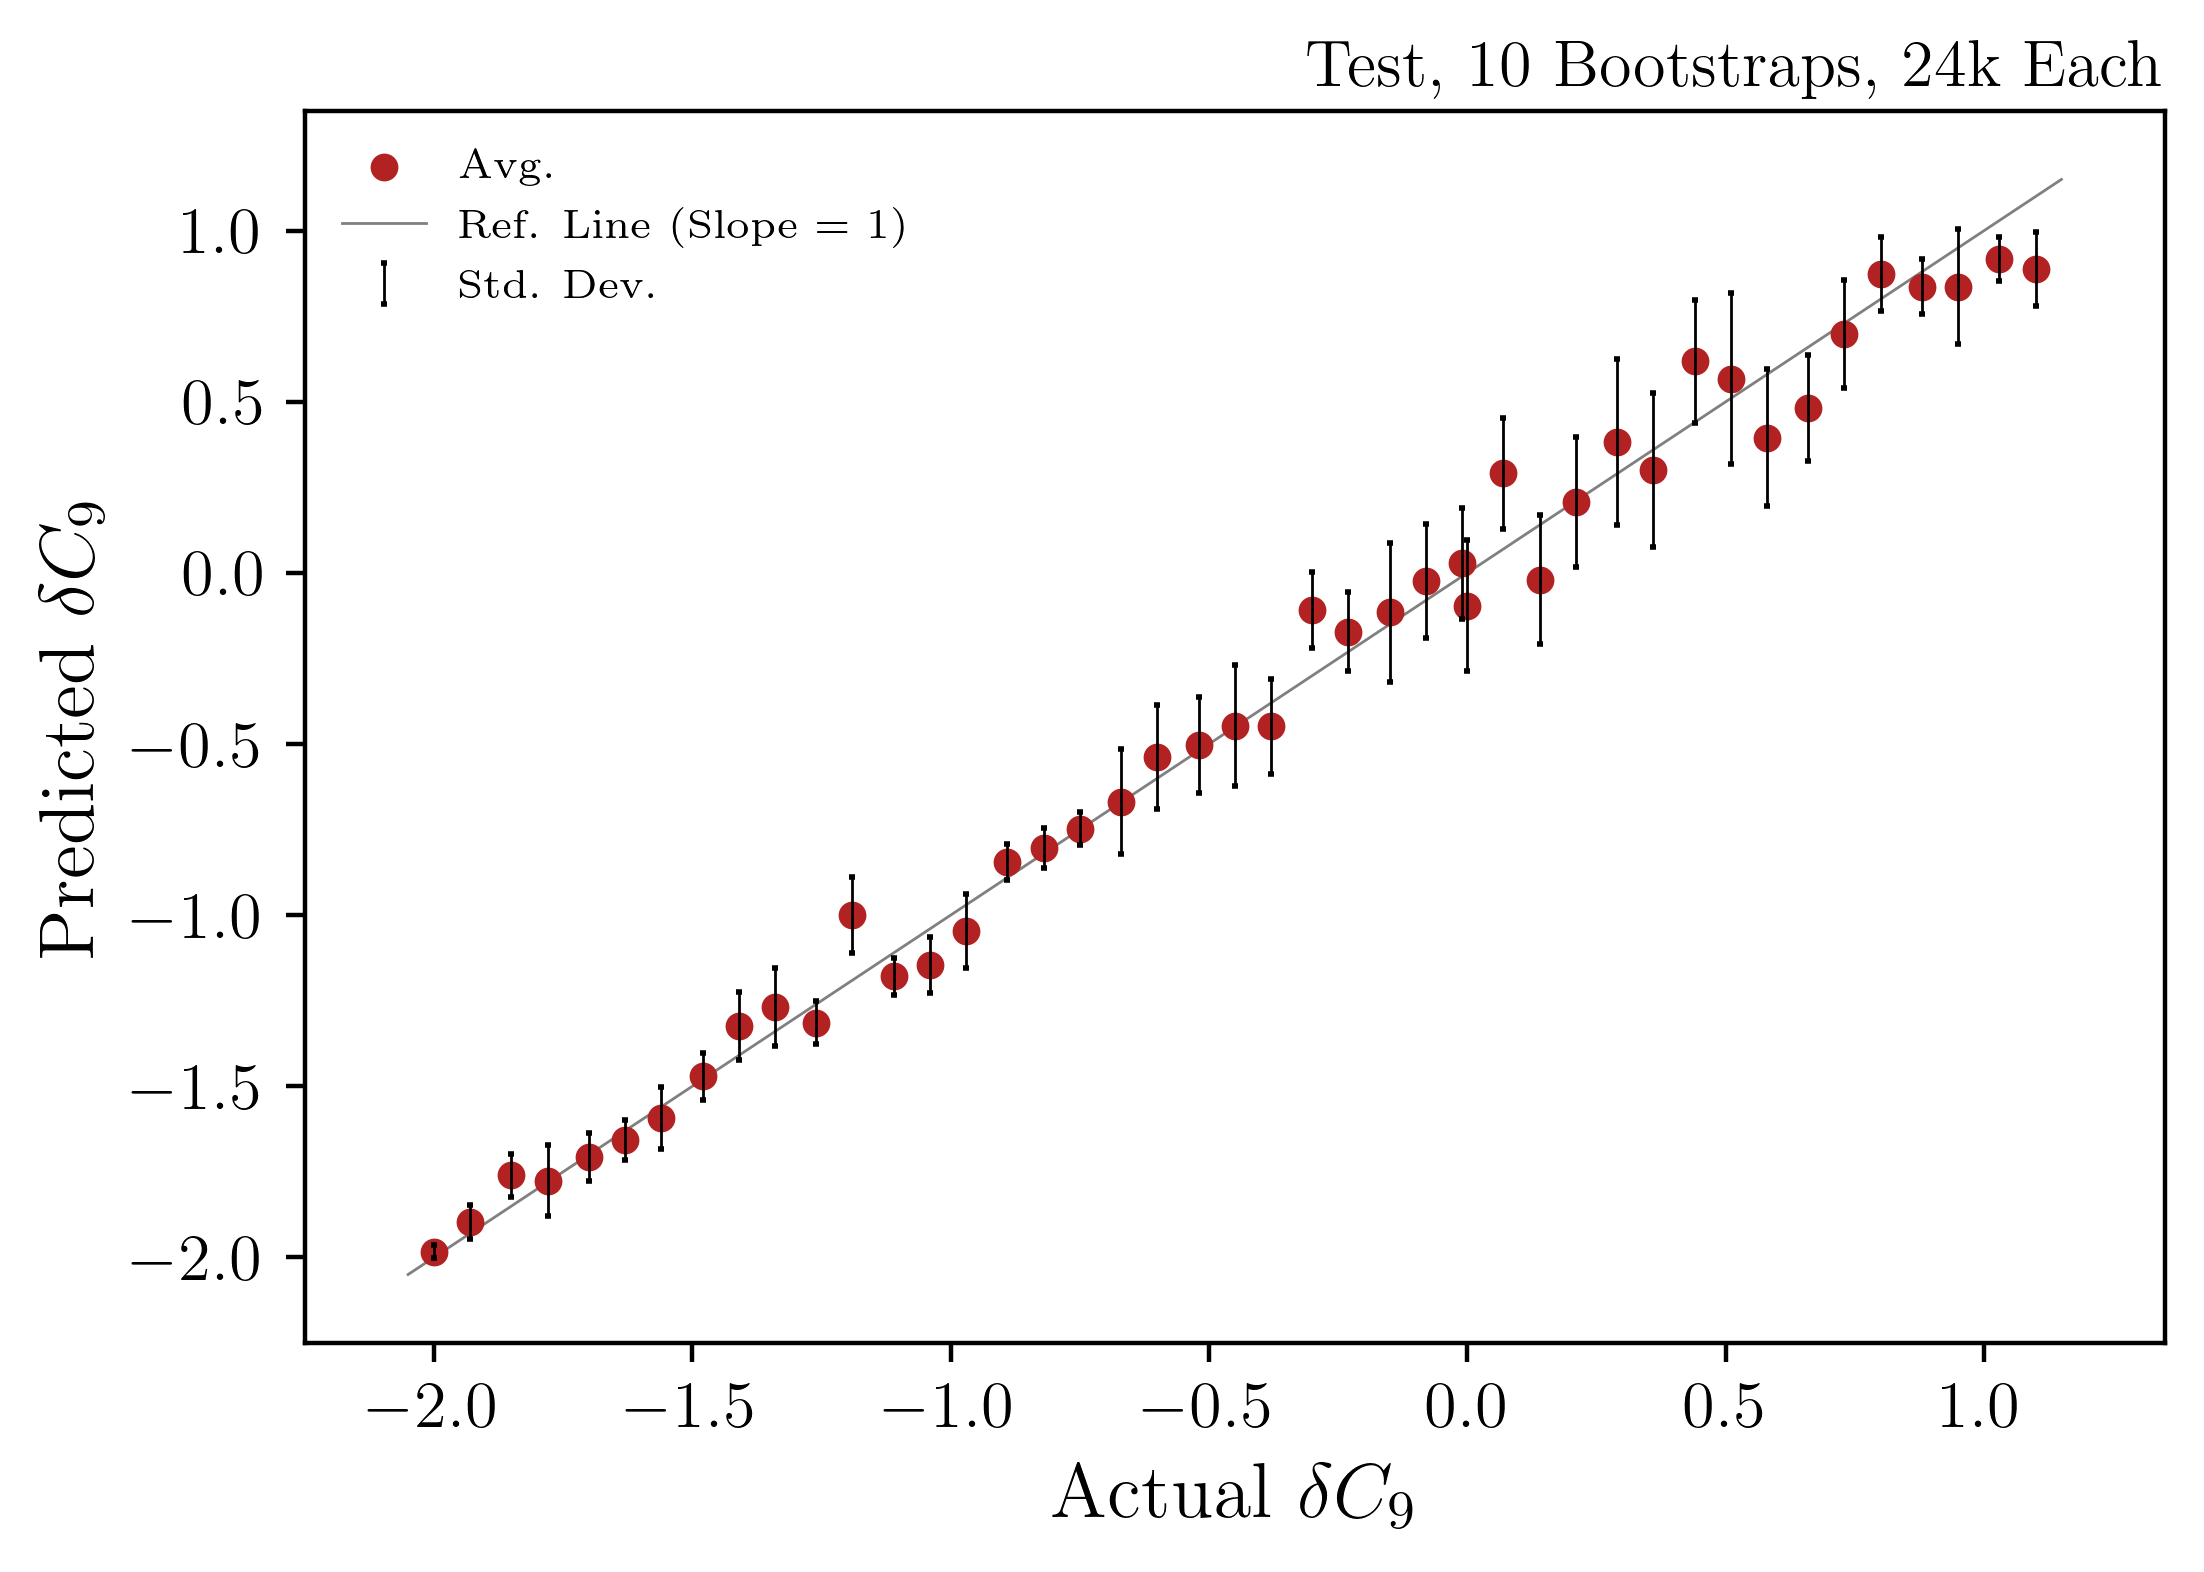

In [13]:
_, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    shifted_bin_values - np.abs(np.min(test_dataset.bin_values)) - 1, # unshifted, E[x + a] = E[x] + a 
    avg_expected_values - np.abs(np.min(test_dataset.bin_values)) - 1, 
    stdev_expected_values, 
    ref_line_buffer=0.05, 
    xlim=(-2.25, 1.35), 
    ylim=(-2.25, 1.35), 
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, "Test, 10 Bootstraps, 24k Each", fontsize="large")

In [73]:
loss_24k = log_loss_over_bootstrapped_trials(test_x, test_y, 10, 24_000, clf)

In [74]:
loss_24k

np.float64(-2.4950472140876876)

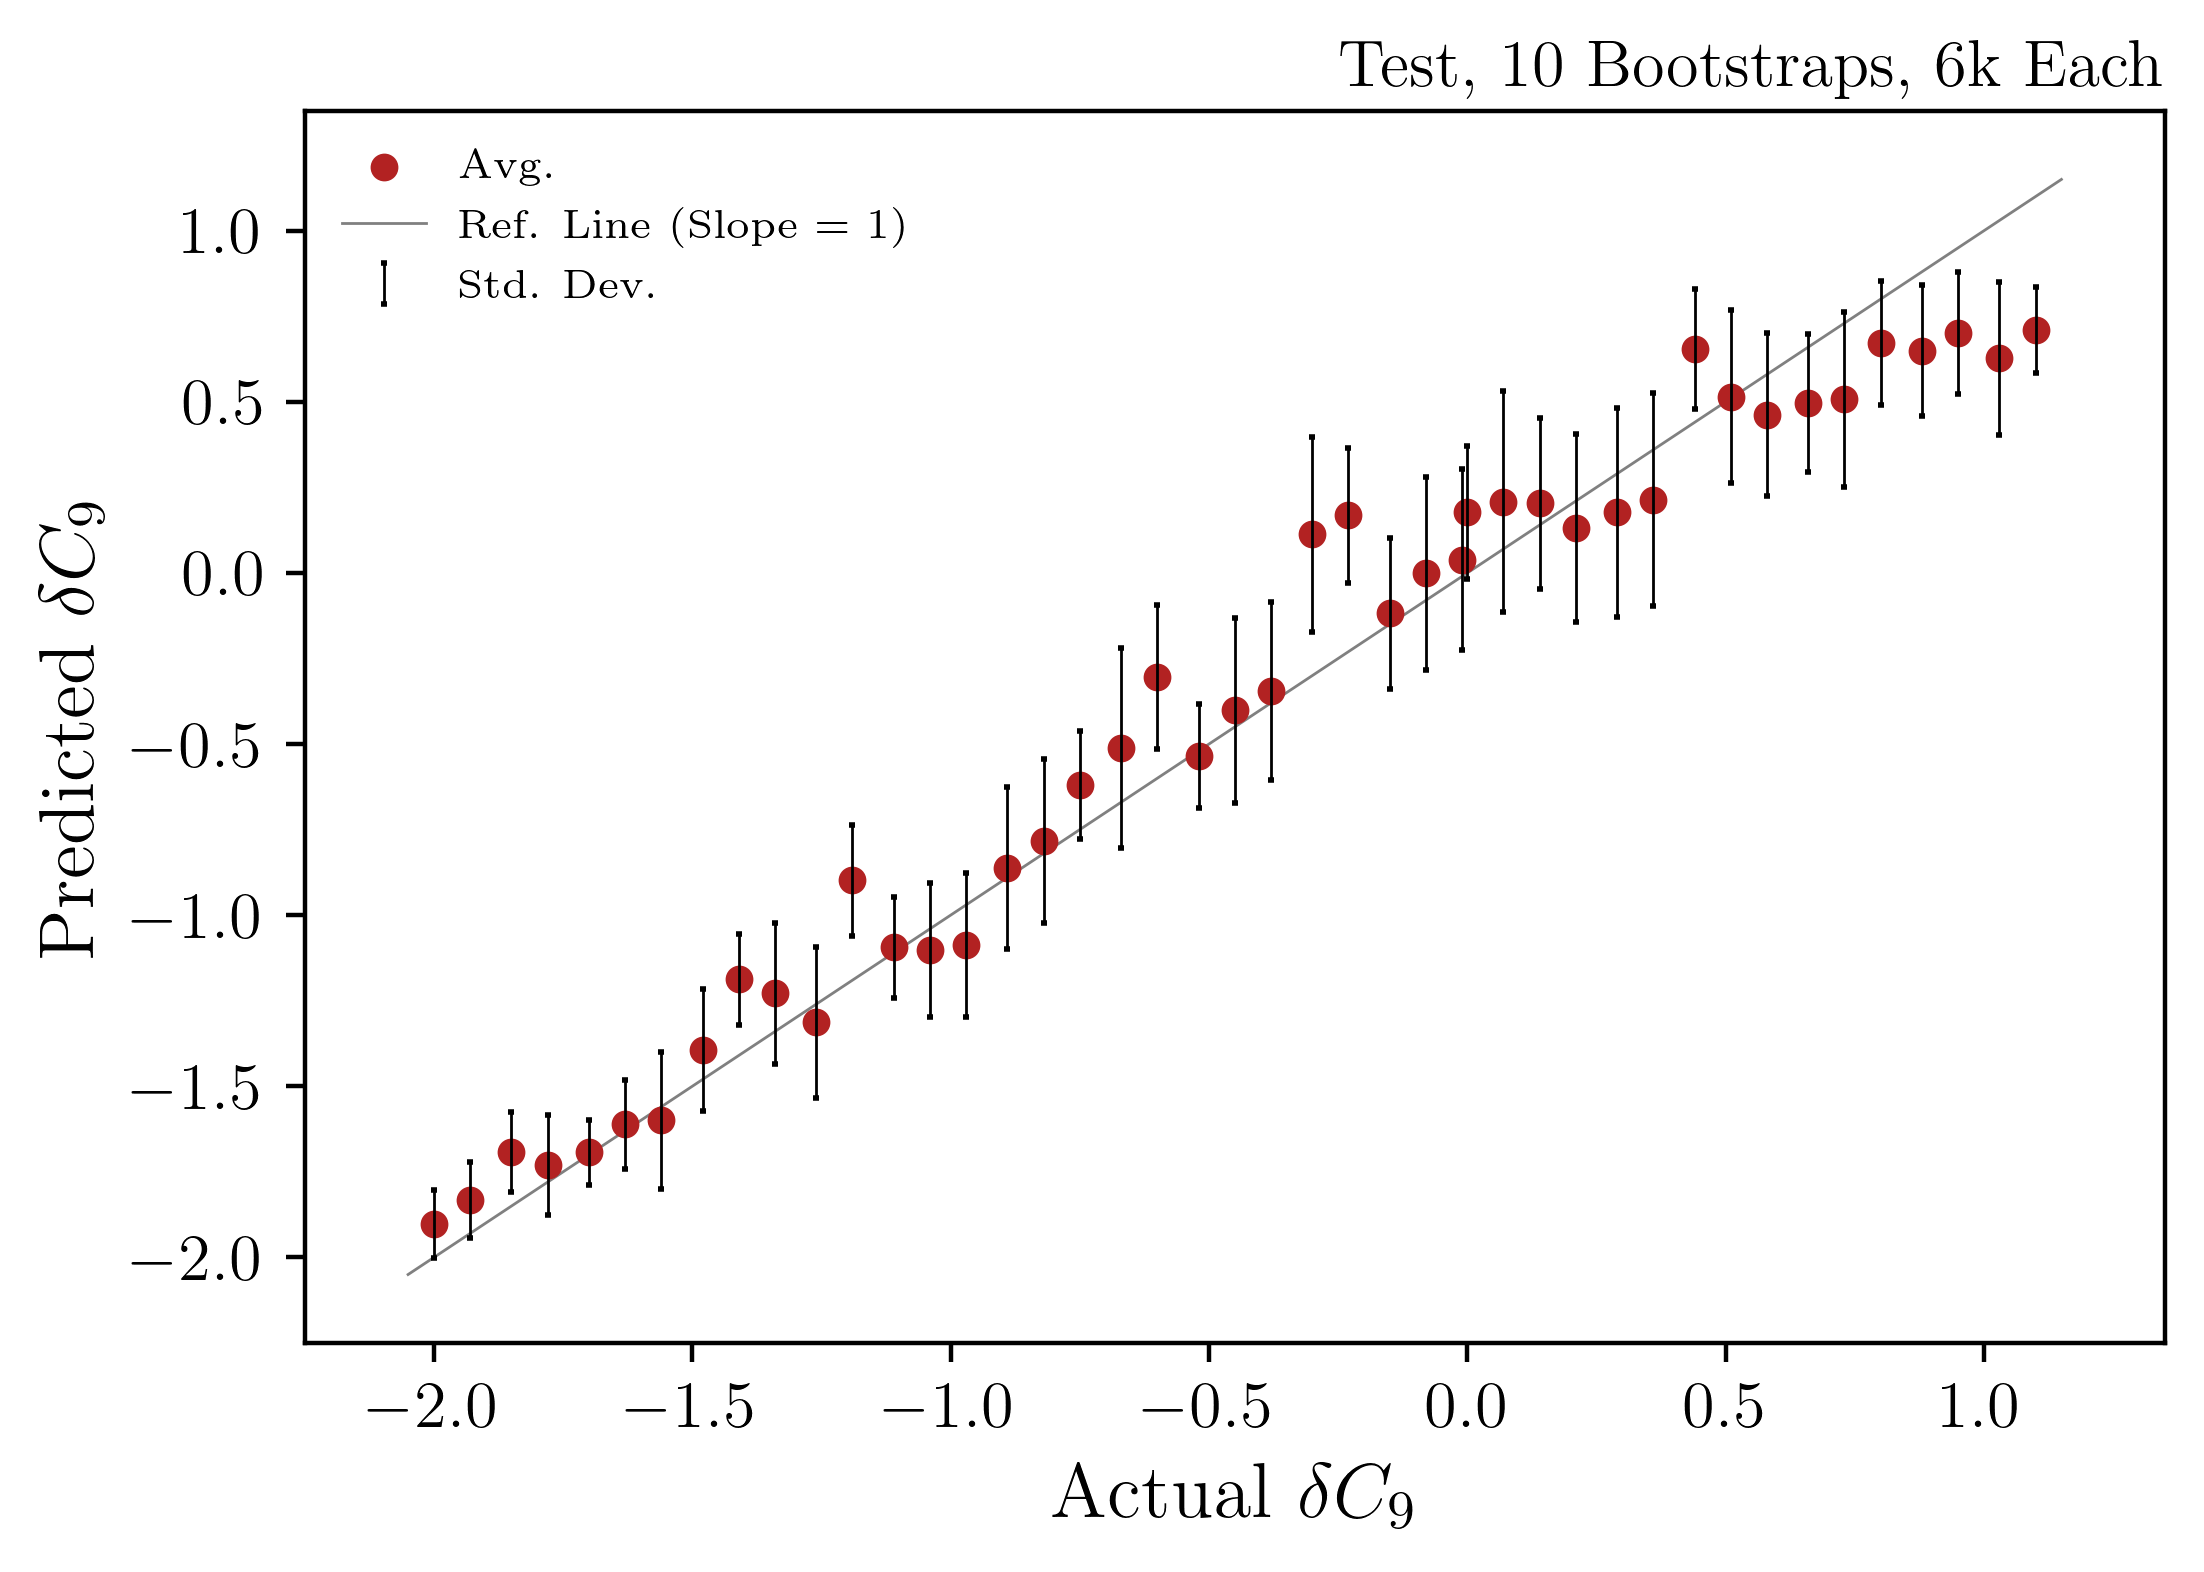

In [14]:
# Over multiple bootstrapped trials

shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1

expected_values_over_trials = predict_expected_value_over_bootstrapped_trials(test_x, test_y, 10, 6_000, clf, shifted_bin_values)

avg_expected_values = np.mean(expected_values_over_trials, axis=0)
stdev_expected_values = np.std(expected_values_over_trials, axis=0)

_, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    shifted_bin_values - np.abs(np.min(eval_dataset.bin_values)) - 1, # unshifted, E[x + a] = E[x] + a 
    avg_expected_values - np.abs(np.min(eval_dataset.bin_values)) - 1, 
    stdev_expected_values, 
    ref_line_buffer=0.05, 
    xlim=(-2.25, 1.35), 
    ylim=(-2.25, 1.35), 
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, "Test, 10 Bootstraps, 6k Each", fontsize="large")

In [75]:
loss_6k = log_loss_over_bootstrapped_trials(test_x, test_y, 10, 6_000, clf)
loss_6k

np.float64(-2.6939119482968223)

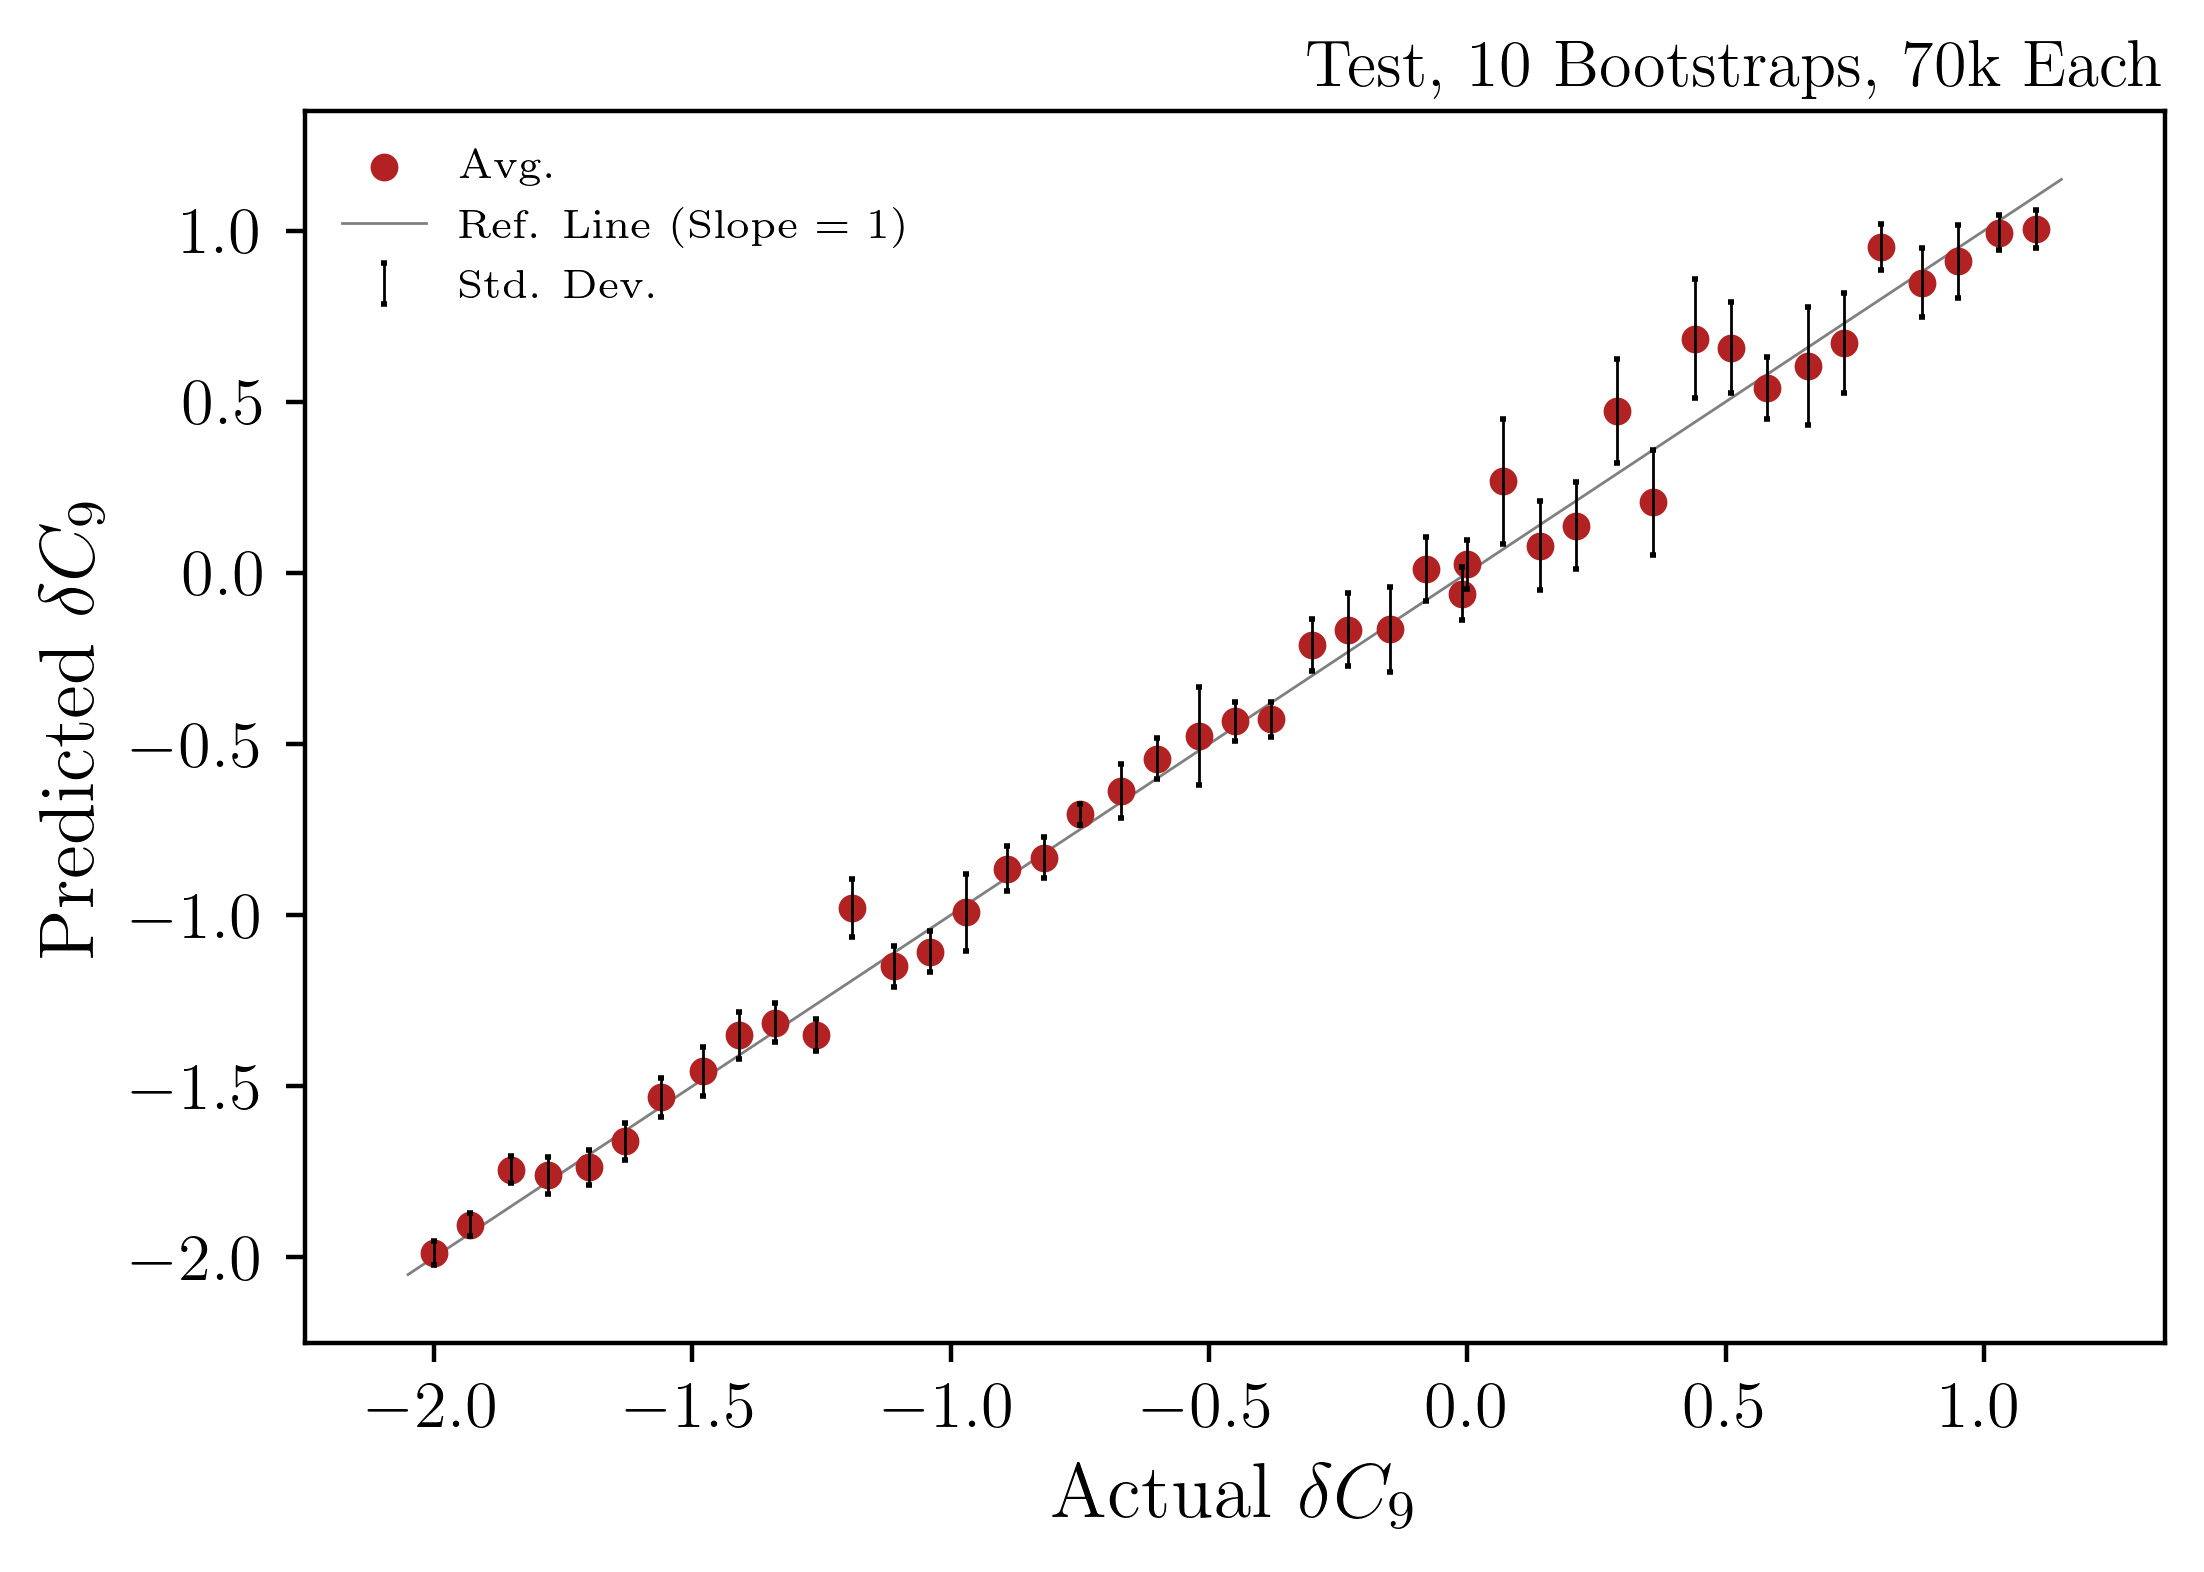

In [15]:
# Over multiple bootstrapped trials

shifted_bin_values = eval_dataset.bin_values + np.abs(np.min(eval_dataset.bin_values)) + 1

expected_values_over_trials = predict_expected_value_over_bootstrapped_trials(test_x, test_y, 10, 70_000, clf, shifted_bin_values)

avg_expected_values = np.mean(expected_values_over_trials, axis=0)
stdev_expected_values = np.std(expected_values_over_trials, axis=0)

_, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    shifted_bin_values - np.abs(np.min(eval_dataset.bin_values)) - 1, # unshifted, E[x + a] = E[x] + a 
    avg_expected_values - np.abs(np.min(eval_dataset.bin_values)) - 1, 
    stdev_expected_values, 
    ref_line_buffer=0.05, 
    xlim=(-2.25, 1.35), 
    ylim=(-2.25, 1.35), 
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, "Test, 10 Bootstraps, 70k Each", fontsize="large")

In [76]:
loss_70k = log_loss_over_bootstrapped_trials(test_x, test_y, 10, 70_000, clf)

In [77]:
loss_70k

np.float64(-3.1887080268667143)